In [1]:
# Leo Simpson, University of Freiburg, Tool-Temp AG, 2023

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
import sys, os
from os.path import join, dirname
main_dir = dirname(os.getcwd())
sys.path.append(main_dir)

In [4]:
import numpy as np
from time import time
import matplotlib.pyplot as plt # type: ignore
import casadi as ca # type: ignore
from src import ProblemParser, ModelParser # main objects to use the present algorithms
from src import plot_data, plot_est, plot_res # plotting tools
rng = np.random.default_rng(seed=0)

In [5]:
dt = 1.
beta_min = 1e-6
Text = 0.
alpha_max = 0.5

def dynamic(x, u, alpha, beta):
    T1 = u[0]
    T2 = x[0]
    T3 = x[1]
    T4 = x[2]
    a_middle = alpha[0]
    aext = alpha[1]
    nx = 3

    # equations of the system
    T2_plus = T2 + dt * a_middle * (T1 - T2)
    T3_plus = T3 + dt * a_middle * (T2 - T3)
    T4_plus = T4 + dt *( a_middle * (T3 - T4) + aext * (Text - T4))
    
    # construction of the output
    x_plus = ca.vcat([T2_plus, T3_plus, T4_plus])
    y = ca.vcat([T2, T4])
    ny = 2
    
    # noise model
    Q =  beta[0] *  ca.DM.eye(nx)
    R =  beta[1] *  ca.DM.eye(ny)
    
    # inequality constraints on the form h > 0
    h = ca.vertcat(alpha, alpha_max - alpha, beta - beta_min)
    return x_plus, y, Q, R, h

In [6]:
# Define the model with Casadi symbolics
x_symbol = ca.SX.sym("x", 3)
u_symbol = ca.SX.sym("u", 1)
alpha_symbol = ca.SX.sym("alpha", 2)
beta_symbol = ca.SX.sym("beta", 2)
xplus_symbol, y_symbol, Q_symbol, R_symbol, h_symbol = dynamic(x_symbol, u_symbol, alpha_symbol, beta_symbol)

In [7]:
# Define a Casadi functions associated with the model
xplus_fn = ca.Function("xplus", [x_symbol, u_symbol, alpha_symbol], [xplus_symbol])
y_fn = ca.Function("y", [x_symbol], [y_symbol])
Q_fn = ca.Function("Q", [beta_symbol], [Q_symbol])
R_fn = ca.Function("R", [beta_symbol], [R_symbol])
h_fn = ca.Function("h", [alpha_symbol, beta_symbol], [h_symbol])

# Problem definition

In [8]:
Ntrain = 3000

model_true = ModelParser(xplus_fn, y_fn, Q_fn, R_fn)
model_true.Ineq = h_fn
model = ModelParser(xplus_fn, y_fn, Q_fn, R_fn)
model.Ineq = h_fn

x0 = np.zeros(model_true.nx)
P0 = np.eye(model_true.nx) * 0.

# Data generation 

In [9]:
umax = 50
us_train = model_true.generate_u(rng, Ntrain, umax=umax, step = 10)

In [10]:
# noise in the true data
alpha_true, beta_true = model_true.draw(rng) # choose a "true parameter randomly"

In [11]:
ys_train, _ = model_true.simulation(x0, us_train, alpha_true,  beta_true, rng)

assert model_true.feasible(alpha_true, beta_true), "Constraints should be satisfied for the true parameters"

# Estimation

In [12]:
alpha_true, beta_true

(array([0.29971189, 0.42268722]), array([0.02831967, 0.12428328]))

In [13]:
# the flag lti allow to speed things up for LTI systems 
problemTrain =ProblemParser(
    model, ys_train, us_train, x0, P0, lti=True)
formulation = "Exact"  # can be "Exact", "Approx"

In [14]:
dict_opts = {
    "SQP":{"pen_step":1e-4, "maxiter":20, "tol.direction":0., "tol.kkt":1e-8}, # parameters of the SQP method
    "IPOPT":{} # use default parameters of IPOPT
}
Ns = [200, 500, 1000, 1500]
def diff(x1, x2):
    return np.sum((x1-x2)**2)

In [15]:
## Optimize over the Kalman filter
res = {}

alpha0 = np.ones(model.nalpha) * 0.2
beta0 = np.ones(model.nbeta) * 0.2
for algorithm in ["IPOPT", "SQP"]:
    infos = {}
    for N in Ns:
        print("Algorithm : {}, N = {}".format(algorithm, N))
        problemTrain.cut(N)
        t0 = time()
        alpha, beta, stats = problemTrain.solve(alpha0, beta0,
                                                formulation, algorithm,
                                                opts=dict_opts[algorithm], verbose=False)
        rtime = time() - t0
        error_alpha = diff(alpha, alpha_true)
        error_beta = diff(beta, beta_true)
        error = error_alpha + error_beta
        if algorithm == "SQP":
            niter = stats['niter']
        else:
            niter = 1
        info = {
                "rtime": rtime,
                "status":stats["return_status"],
                "rtime-per-iter": rtime/niter,
                "alpha": alpha.copy(),
                "beta": beta.copy(),
                "alpha_true": alpha_true.copy(),
                "beta_true": beta_true.copy(),
                "error": error,
                "error_alpha":error_alpha,
                "error_beta":error_beta
            }
        infos[N] = info
        print("rtime : {:.2e}  status : {}".format(rtime, stats["return_status"]))
        
        alpha0 = alpha.copy() # for making faster, to remove
        beta0 = beta.copy()
        
    res[algorithm] = infos

Algorithm : IPOPT, N = 200
rtime : 1.14e+00  status : Solve_Succeeded
Algorithm : IPOPT, N = 500
rtime : 2.85e+00  status : Solve_Succeeded
Algorithm : IPOPT, N = 1000
rtime : 6.56e+00  status : Solve_Succeeded
Algorithm : IPOPT, N = 1500
rtime : 1.13e+01  status : Solve_Succeeded
Algorithm : SQP, N = 200
rtime : 4.64e-01  status : tol.direction
Algorithm : SQP, N = 500
rtime : 1.22e+00  status : tol.direction
Algorithm : SQP, N = 1000
rtime : 2.16e+00  status : tol.direction
Algorithm : SQP, N = 1500
rtime : 3.70e+00  status : rtol.cost_decrease


In [16]:
for algorithm, infos in res.items():
    print("solution for", algorithm)
    for N, info in infos.items():
        print("N = {}".format(N))
        print("Running time : {:.2e}".format(info["rtime"]))
        print("Error : {:.2e}".format(info["error"]))
        print("Status : {}".format(info["status"]))
        print("beta_true : {}".format(info["beta_true"]))
        print("beta : {}".format(info["beta"]))
        print("alpha_true : {}".format(info["alpha_true"]))
        print("alpha : {}".format(info["alpha"]))

        print(" ")
    print(" ")

solution for IPOPT
N = 200
Running time : 1.14e+00
Error : 5.38e-04
Status : Solve_Succeeded
beta_true : [0.02831967 0.12428328]
beta : [0.0132862  0.12805801]
alpha_true : [0.29971189 0.42268722]
alpha : [0.30653797 0.43853498]
 
N = 500
Running time : 2.85e+00
Error : 9.27e-05
Status : Solve_Succeeded
beta_true : [0.02831967 0.12428328]
beta : [0.0230722  0.12159584]
alpha_true : [0.29971189 0.42268722]
alpha : [0.30179755 0.43000493]
 
N = 1000
Running time : 6.56e+00
Error : 6.38e-05
Status : Solve_Succeeded
beta_true : [0.02831967 0.12428328]
beta : [0.0253471  0.12238723]
alpha_true : [0.29971189 0.42268722]
alpha : [0.30142012 0.4296453 ]
 
N = 1500
Running time : 1.13e+01
Error : 1.80e-05
Status : Solve_Succeeded
beta_true : [0.02831967 0.12428328]
beta : [0.02814072 0.12403849]
alpha_true : [0.29971189 0.42268722]
alpha : [0.29689809 0.41951983]
 
 
solution for SQP
N = 200
Running time : 4.64e-01
Error : 5.39e-04
Status : tol.direction
beta_true : [0.02831967 0.12428328]
beta

<IPython.core.display.Javascript object>


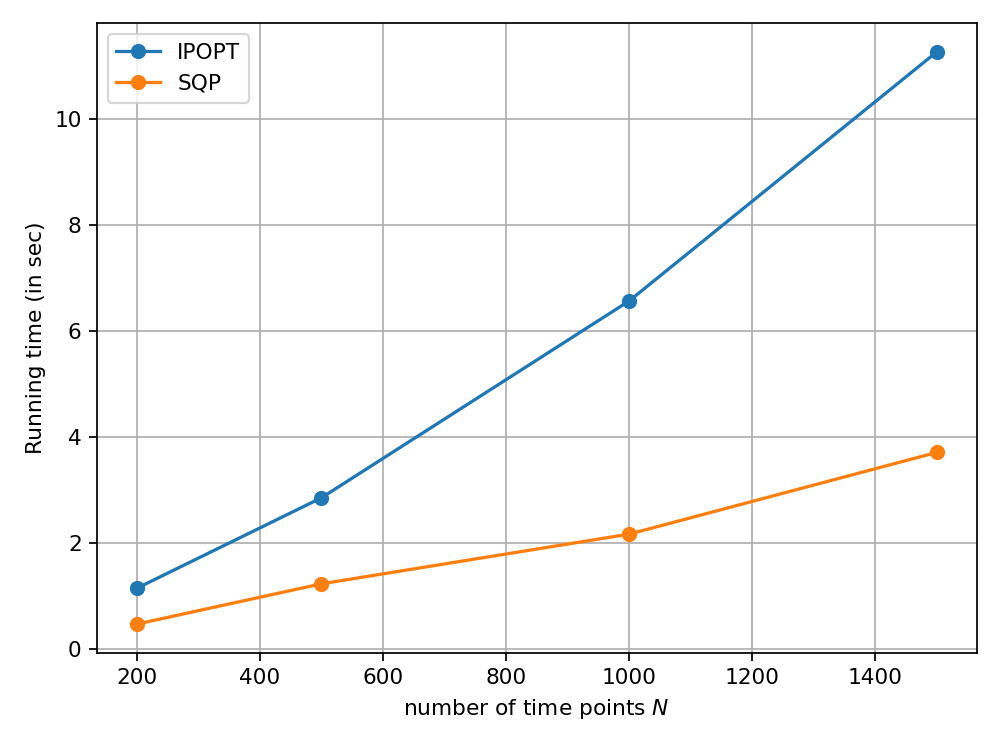

In [17]:
fig = plot_res(res, "rtime", scale="lin")

<IPython.core.display.Javascript object>


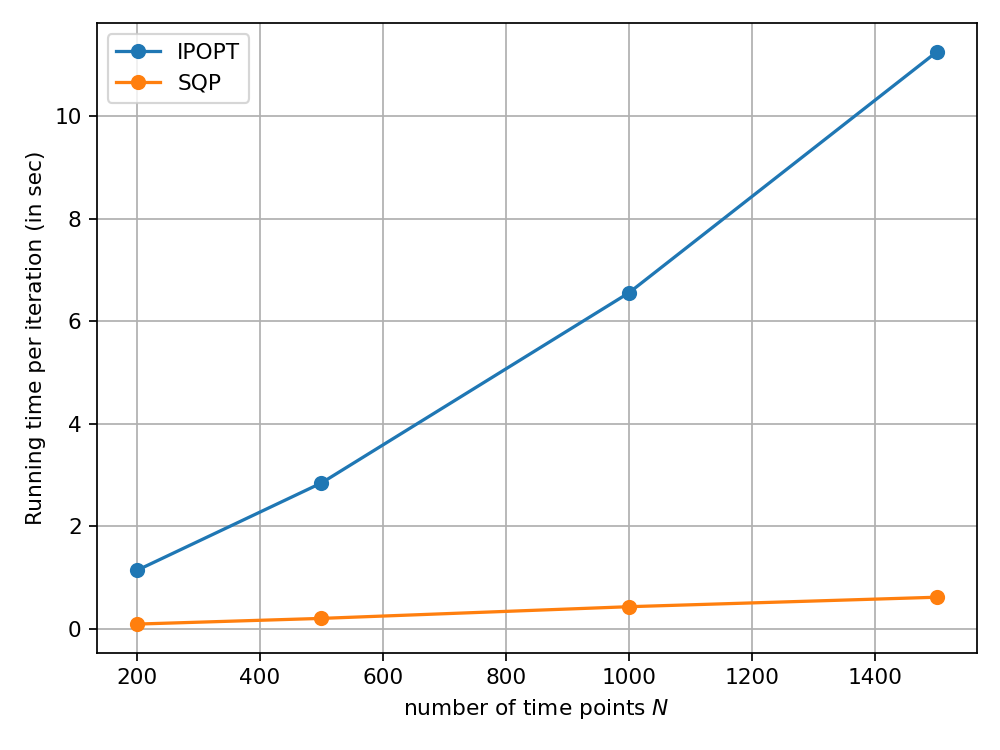

In [18]:
fig = plot_res(res, "rtime-per-iter", scale="lin")

<IPython.core.display.Javascript object>


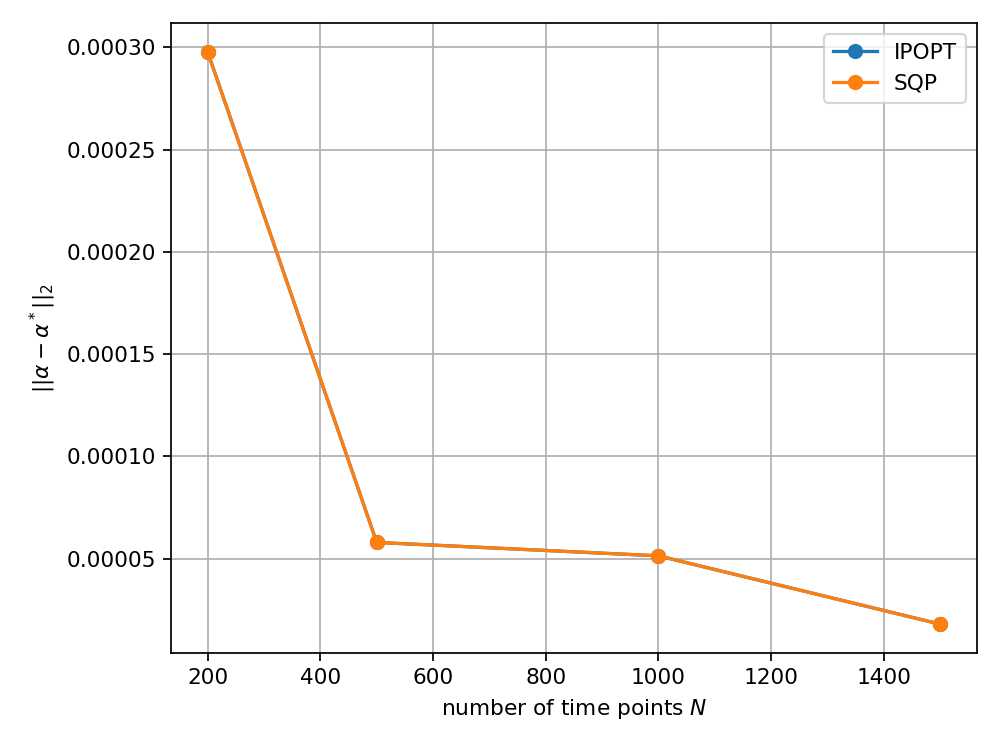

In [19]:
fig = plot_res(res, "error_alpha")

<IPython.core.display.Javascript object>


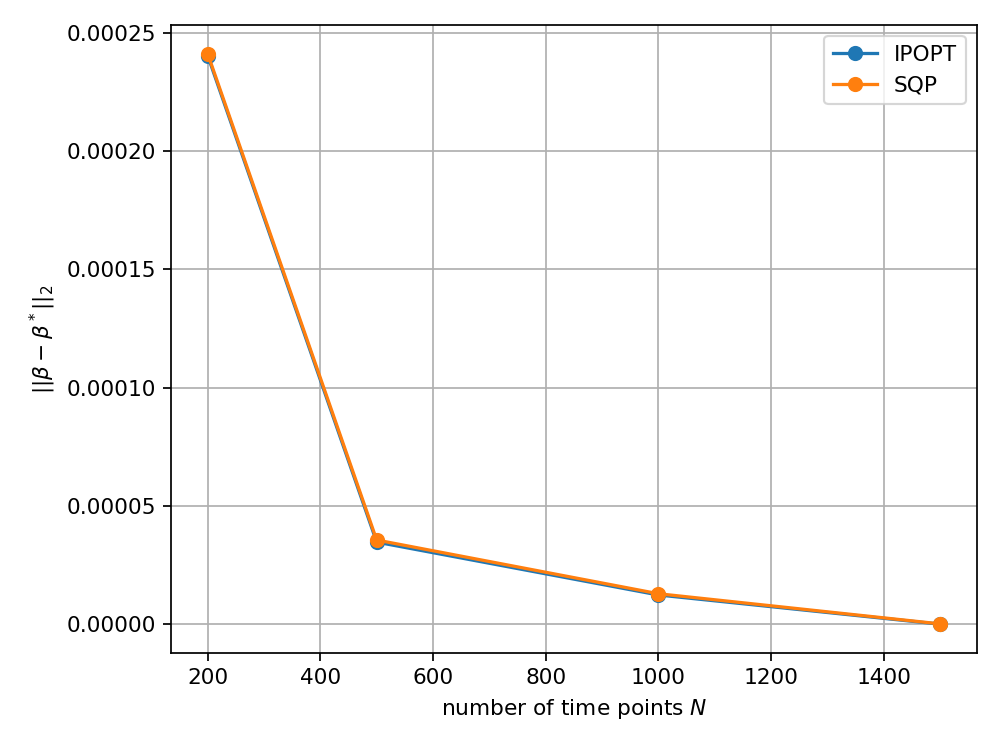

In [20]:
fig = plot_res(res, "error_beta")